In [1]:
library(bnlearn) |> suppressPackageStartupMessages()
library(Rgraphviz) |> suppressPackageStartupMessages()
library(tidyverse) |> suppressPackageStartupMessages()
library(gtools) |> suppressPackageStartupMessages()
library(bnstruct) |>suppressPackageStartupMessages()
library(parallel) |> suppressPackageStartupMessages()

In [2]:
factor_remover <- function(dataset) {
    cols <- colnames(dataset)
    for (i in seq_along(cols)) {
        name <- cols[i]
        dataset[[name]] <- as.character(dataset[[name]])
    }
    return(dataset)
}


dataset <- function(dataset) {
    if (class(dataset) == 'data.frame') {
        return(factor_remover(dataset))
    } else {
        df <- as.data.frame(raw.data(dataset))
        colnames(df) <- dataset@variables
        return(df)
    }
}

In [3]:
node.values <- function(dataset, parents) {
    # retrieves the unique values of the nodes
    #return a list of vectors, 
    # each vector contains the unique values of the corresponding node
    output <- list()
    for (kk in seq_along(parents)) {
        node <- parents[kk]
        node.vals <- unique(dataset[[node]]) #it was levels()
        output[[kk]] <- node.vals
    }
    return(output)
}

In [4]:
fastalphaijk <- function(i, pii, dataset, nodes.order, smooth=FALSE) {
    actual_node <- nodes.order[i]
    all.nodes <- c(pii, actual_node)
    subset <- dataset[all.nodes]
    unique.instantiations <- expand.grid(node.values(dataset, all.nodes))
    colnames(unique.instantiations) <- colnames(subset)
    subset.counted <- subset |> group_by(across(everything())) |> summarise(n = n(), .groups="drop")
    checking <-  left_join(unique.instantiations, subset.counted, by=colnames(subset), na_matches="na")  |> arrange(across(-last_col()))
    checking$n[is.na(checking$n)]<- 0
    if (smooth) {
        checking$n <- checking$n + 1   # SOFIA's laplace smoothing
    } else {}
    #cat("\n")
    #print(checking)
    #cat( "\n \n")
    return(checking$n)
}

In [5]:
k2helper <- function(i, pii, dataset, nodes.order, log=TRUE) {
    # the "f" function in the pdf
    #cat("\n------------------\n")
    phi_i <- expand.grid(node.values(dataset, pii)) 
    #cat("\nphi.i")
    #print( phi_i)
    q_i <- dim(phi_i)[1] # works good
    #cat("\nqi.i", q_i)
    i.th.node <- nodes.order[i]
    #cat("\nithnode", i.th.node)
    v_i <- node.values(dataset, i.th.node)
    #cat("\nvi")
    #print(v_i)
    r_i <- length(v_i[[1]])
    #cat("\nri", r_i)
    individual_alphas <- fastalphaijk(i, pii, dataset, nodes.order) # works good
    #cat("\nindividual alphas::",individual_alphas)
    #aijk <- prod(factorial(individual_alphas)) ##
    grouping_alphas <- matrix(individual_alphas, nrow=r_i) # to get the right Nijs
    nij <- colSums(grouping_alphas)
    #print(nij)
    
    produttoria_alpha <- prod(lfactorial(individual_alphas))
    log_produttoria_alpha <- sum(lfactorial(individual_alphas))
    log_numeratore <- sum(lfactorial(rep(r_i-1,q_i))) # r_i - 1 + 1 = r_i
    numeratore <- factorial(r_i-1)
    log_denominatore <- sum(lfactorial(nij + r_i-1)) # nij + r_i - 1 + 1 = nij + r_i
    denominatore <- factorial(nij+r_i-1)
    log_out <- log_numeratore - log_denominatore + log_produttoria_alpha
    out1 <- prod((numeratore/denominatore))*produttoria_alpha
    out2 <- sum(log_out)
    #cat("logout", log_out)
    ifelse(log, out <- out2, out<- out1)
    #cat("\nproduttoria_alpha",produttoria_alpha )
    #cat("\nproduttoria_alpha",produttoria_alpha )
    #print(frazione)
    return(out)
}

In [6]:
k2 <- function(dataset, nodes.order, upperbound) {
    start <- Sys.time()  # SOFIA

    nodes <- colnames(dataset)           # node names
    net.dag <- empty.graph(nodes=nodes) # network DAG (Directed Acyclic Graph)
    edges <- list()  # ← new: store edges here  SOFIA
    
    
    for (i in seq_along(nodes.order)) {
        actual_node <- nodes.order[i]
        #cat("\n", i,"\n")
        pii <- c()
        p.old <- k2helper(i, pii,dataset, nodes.order)
        proceed <- TRUE
        #cat("\ni::",i, "\n")
        p.new.container <- c()
        while (proceed && length(pii) <= upperbound) {
            predecessors_idx <- i-1
            predecessors <- nodes.order[0:predecessors_idx]
            #cat("\npredecessors::", predecessors, " pii:: ", pii)
            piiuz <- setdiff(predecessors, pii)
            if (length(piiuz) > 1) {
                daddy.s.probs <- c()
                for (daddy in seq_along(piiuz)) {
                    p.new <- k2helper(i, c(pii, piiuz[daddy]), dataset, nodes.order)
                    daddy.s.probs <- c(daddy.s.probs, c(p.new))
                }
                p.new <- max(daddy.s.probs)
                #cat("\npnew", p.new, "pold", p.old)
                eventuale.genitore <-  piiuz[daddy.s.probs == p.new]
            } else {
                p.new <- k2helper(i, piiuz, dataset, nodes.order)
                eventuale.genitore <- piiuz
            }
            #cat("\npiiuz:: ",piiuz,"\np.old:: ", p.old, "\np.new:: ", p.new)    #edge_matrix <- do.call(rbind, edges)

            #roof <- roof+1
            if (p.new > p.old) {
                p.old <- p.new
                pii <- c(pii, eventuale.genitore)
                p.new.container <- c(p.new.container, p.new)
                net.dag <- set.arc(net.dag, from=eventuale.genitore, to=actual_node)
                #ifelse(roof>length(nodes)^length(nodes), proceed <- FALSE, proceed <- TRUE)
            } else  {
                proceed <- FALSE
            }
        }
        #cat('\nNode', nodes.order[i], '--> Parents:', pii,'\n') 
        
        # Store edges: each pii is a parent of actual_node  SOFIA
        if (length(pii) >= 0) {
            for (iterator in seq_along(pii)) {
                parent <- pii[iterator]
                edges[[length(edges) + 1]] <- c(parent, actual_node)
            }
        }

    }
    
    net.score <- score(net.dag, dataset |> mutate_all(as_factor) |> as.data.frame()) # network scor
    # Convert to matrix or return edge list
    edge_matrix <- do.call(rbind, edges)
    
    end <- Sys.time()
    execution_time <- difftime(time1 = end, time2 = start, units = "secs") 
    cat("\nExecution Time:", execution_time, "s")
    
    return(list('edges' = edge_matrix, 
                'dag' = net.dag,
                'score' = net.score))
}

## Explorer Function

In [7]:
explo_scorer_single <- function(dataset, n_permutations = 1000, upperbound=2) {
  start <- Sys.time()
  
  set.seed(8)
  cols <- colnames(dataset)
  
  
  
  ncols <- length(cols)
  
  if(ncols <= 7){
    permutations <- permutations(n = ncols, r = ncols, v = cols)
    row_limit <- nrow(permutations)
  } else {
    # Sample random permutations (shuffles) for large ncols
    row_limit <- n_permutations
  }

  result <- k2(dataset, cols, upperbound = upperbound)
  best.dag <- list(result$dag)
  best.score <- c(result$score)
  best.order <- list(cols)
  
  for(i in 2:row_limit){
    if(ncols <= 7){
      row_permutation <- permutations[i, ]
    } else {
      row_permutation <- sample(cols, size = ncols, replace = FALSE)
    }
    result <- k2(dataset, row_permutation, upperbound=upperbound)
    #if (result$score > best.score) {
    #  best.dag <- result$dag
    #  best.score <- result$score
    #  best.order <- row_permutation
    #}
    best.dag[i] <- result$dag
    best.score[i] <- result$score
    best.order[i] <- row_permutation
    #cat('Running iteration', i, "\n")
  }
  idx <- which.max(best.score)
  
  end <- Sys.time()
  execution.time <- difftime(time1 = end, time2 = start, units = "secs")
  #cat("\nExecution Time:", execution.time, "s\n")
  
  # Return best.score or best ordering if needed
  return(list('dag'=best.dag[[idx]], 'order'=best.order[[idx]], 'exec_time'=execution.time))
}
explo_scorer <- function(dataset, n_permutations = 1000, upperbound=2) {
  start <- Sys.time()
  set.seed(8)
  cols <- colnames(dataset)
  ncols <- length(cols)
  
  if(ncols <= 7){
    permutations <- permutations(n = ncols, r = ncols, v = cols)
    row_limit <- nrow(permutations)
    perm_list <- split(permutations, seq(nrow(permutations)))
  } else {
    row_limit <- n_permutations
    perm_list <- lapply(1:row_limit, function(i) sample(cols, size = ncols, replace = FALSE))
  }

  # Parallel evaluation
  results <- mclapply(perm_list, function(row_permutation) {
    result <- k2(dataset, row_permutation, upperbound=upperbound)
    list(dag = result$dag, score = result$score, order = row_permutation)
  }, mc.cores = detectCores() - 1)

  # Extract scores and find the best
  scores <- sapply(results, function(x) x$score)
  idx <- which.max(scores)
  
  end <- Sys.time()
  execution.time <- difftime(time1 = end, time2 = start, units = "secs")
  
  return(list('dag' = results[[idx]]$dag, 'order' = results[[idx]]$order, 'exec_time' = execution.time))
}

## Learning Dataset

In [ ]:
df <- dataset(learning.test)

learning_result <- k2(dataset=df, upperbound = 3, nodes.order = c("A","B","C","D","F","E"))
edges <- learning_result$edges
dag <- learning_result$dag
score <- learning_result$score

cat("\nscore", score)
# Plot it
graphviz.plot(dag)

## Asia Dataset

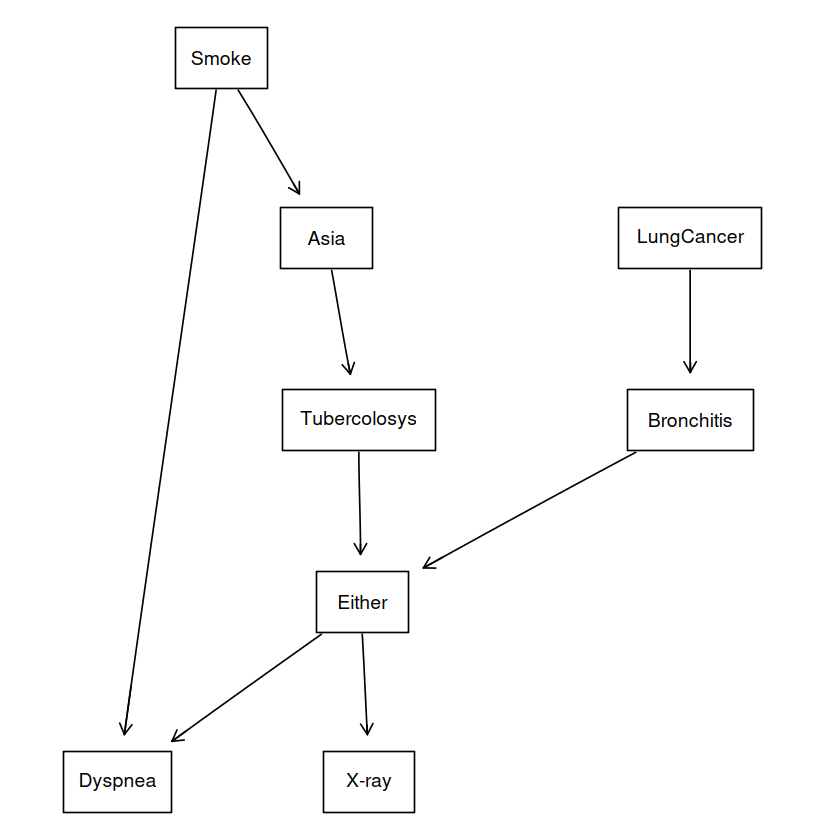

In [8]:
result <- explo_scorer(dataset = dataset(asia()), upperbound = 2,n_permutations = 2000)
graphviz.plot(result$dag)


Execution Time: 0.918982 s

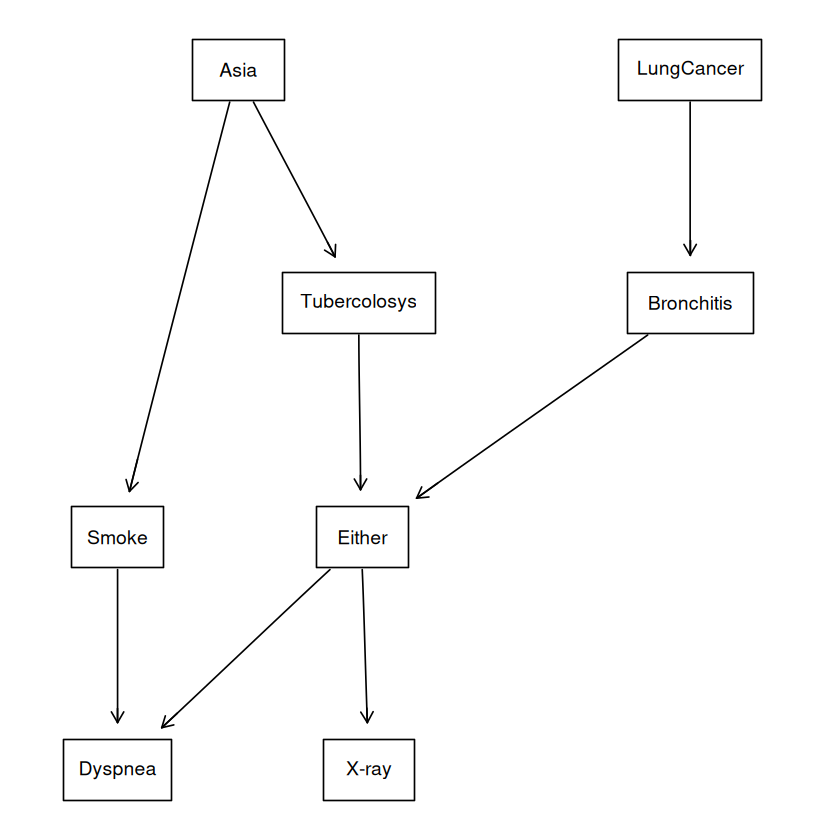

In [9]:
asia_df <- dataset(asia())
ordering_asia <- colnames(asia_df)[c(3,1,2,4,5,6,7,8)]
asia_result <- k2(asia_df, upperbound=3, nodes.order=colnames(asia_df))

edges <- asia_result$edges
dag <- asia_result$dag

# Plot it
graphviz.plot(dag)

## Child Dataset

In [ ]:
child <- dataset(child)
child_result <- k2(child, upperbound=3, nodes.order=colnames(child))

edges <- child_result$edges
dag <- child_result$dag
#g <- graph_from_edgelist(edges, directed = TRUE)

# Plot it
graphviz.plot(dag)